# SMS spam detector

In this project, I am going to develop an machine learning model that classify that a particular sms is spam or ham.
I am using a dataset from the UCI datasets(https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

To get a list of all the lines of text messages:

In [1]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


In [2]:
messages[0:5]

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...',
 "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'ham\tU dun say so early hor... U c already then say...',
 "ham\tNah I don't think he goes to usf, he lives around here though"]

Due to the \t we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself.

Using these labeled ham and spam examples, I train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, I am able to classify arbitrary unlabeled messages as ham or spam

In [3]:
import pandas as pd

In [23]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection',sep = '\t',names = ["label","message"])

In [18]:
messages.head()

,label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
Message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [20]:
messages.describe()

,label,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's make a new column to detect how long the text messages are:

In [21]:
print(messages.groupby('label').describe())

      Message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4


Let's make a new column to detect how long the text messages are:

In [24]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

AxesSubplot(0.125,0.125;0.775x0.755)


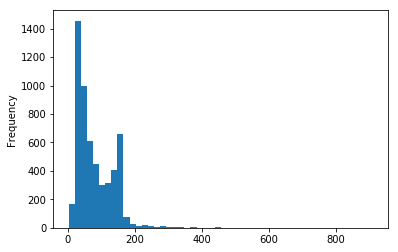

In [28]:
print(messages['length'].plot(bins=50, kind='hist')) 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000200FBDF8B00>,
      dtype=object)

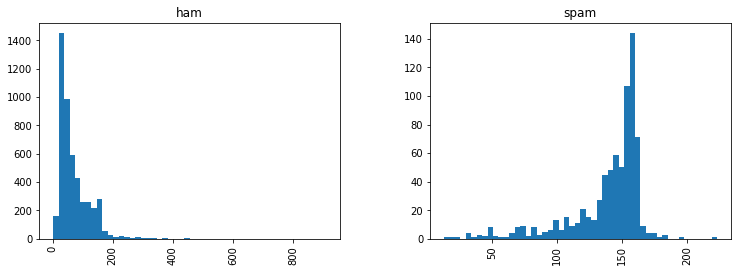

In [29]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

Clearly seen that spam messages tend to have more characters

### Text Pre-processing

Our data is that it is all in text format (strings). The classification algorithms need some sort of numerical feature vector in order to perform the classification task. For this I am using the bag-of-words approach, where each unique word in a text will be represented by one number.
So by this I am convert the raw messages (sequence of characters) into vectors (sequences of numbers).

In [95]:
import string
from nltk.corpus import stopwords #using nltk liberary

Function to remove very common words and process text of entire dataframe

In [33]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [34]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages.

In [35]:
messages['message'].apply(text_process)

0       [Go, jurong, point, crazy, Available, bugis, n...
1                          [Ok, lar, Joking, wif, u, oni]
2       [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3           [U, dun, say, early, hor, U, c, already, say]
4       [Nah, dont, think, goes, usf, lives, around, t...
5       [FreeMsg, Hey, darling, 3, weeks, word, back, ...
6       [Even, brother, like, speak, treat, like, aids...
7       [per, request, Melle, Melle, Oru, Minnaminungi...
8       [WINNER, valued, network, customer, selected, ...
9       [mobile, 11, months, U, R, entitled, Update, l...
10      [Im, gonna, home, soon, dont, want, talk, stuf...
11      [SIX, chances, win, CASH, 100, 20000, pounds, ...
12      [URGENT, 1, week, FREE, membership, £100000, P...
13      [Ive, searching, right, words, thank, breather...
14                                         [DATE, SUNDAY]
15      [XXXMobileMovieClub, use, credit, click, WAP, ...
16                                    [Oh, kim, watching]
17      [Eh, u

### Train Test Split

In [66]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


## Vectorization

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.
We'll do that in three steps using the bag-of-words model:

Count how many times does a word occur in each message (Known as term frequency)

Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

### and then 

the term weighting and normalization are calculated with TF-IDF, using scikit-learn's TfidfTransformer

In [86]:
from sklearn.feature_extraction.text import TfidfTransformer

### And finally 

train on TF-IDF vectors w using Naive Bayes classifier

In [87]:
from sklearn.naive_bayes import MultinomialNB

## This all three steps are done simultaneously by using a methond known as Data Pipelines 

### Creating Data Pipeline

I am using SciKit Learn's pipeline capabilities to store a pipeline of workflow.

In [88]:
from sklearn.pipeline import Pipeline

In [89]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

### Training a model

In [90]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x00000200FE7C9950>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [91]:
predictions = pipeline.predict(msg_test)

### Model Evaluation

In [94]:
from sklearn.metrics import classification_report
print (classification_report(label_test,predictions))

             precision    recall  f1-score   support

        ham       0.96      1.00      0.98       981
       spam       1.00      0.72      0.83       134

avg / total       0.97      0.97      0.96      1115



### Classification report is quite nice. This model now become able to predict weather the sms is spam or not.

### Thanks